# Haplotype analysis *Cyp9k1*

### Color palettes

In [1]:
# define dictionary of pop colors
pop_colours = {
 'Avrankou coluzzii' : "sienna",
 'Korle-Bu coluzzii' : "orange",
 'Baguida gambiae' : "skyblue",
 'Madina gambiae' : "cadetblue",
 'Obuasi gambiae' : "slateblue",
}

dup10_colours = {
    'Dup10 present' : 'mediumorchid',
    'Dup10 absent' : 'lightgray'
}


### Import packages

In [2]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import re
import scipy.cluster
from scipy.stats import spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns



### Load metadata

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

sample_sets = ['1237-VO-BJ-DJOGBENOU-VMF00050', 
               '1244-VO-GH-YAWSON-VMF00051',  
               '1253-VO-TG-DJOGBENOU-VMF00052']
meta = ag3.sample_metadata(sample_sets = sample_sets)
meta['location'] = meta['location'].str.replace('_.*', '', regex=True)
meta['aim_species'] = meta['aim_species'].str.replace('intermediate_gambiae_coluzzii', 'intermediate')

# Now remove males
is_female = meta['sex_call'] == 'F'
meta = meta[is_female]



Load sample metadata:   0%|          | 0/3 [00:00<?, ?it/s]

### Load CNV data

In [4]:
# Identify samples that have Cyp9k1_Dup10
discordant_read_calls = (
    ag3
    .cnv_discordant_read_calls(contig="X", sample_sets=sample_sets)
    .set_index(variants="variant_id")
    .isel(samples = is_female)
)
Dup10_calls = discordant_read_calls.sel(variants = 'Cyp9k1_Dup10').call_genotype
has_Dup10 = Dup10_calls > 0

# In order to known the copy number of Dup10 specifically, we need to ignore samples that have
# both Dup10 and another CNV at Cyp9k1. Dup0 indicates the presence of *any* CNV, and so will 
# be True if the sample has Dup10. We therefore also ignore that column. 
other_cyp9k1_calls = discordant_read_calls.drop_sel(variants = ['Cyp9k1_Dup0', 'Cyp9k1_Dup10']).call_genotype
has_other_cyp9k1_cnv = np.sum(other_cyp9k1_calls, 0) > 0

# Now we can exclude samples that have both Dup10 and another CNV allele, or that have Dup10 
# and are of high coverage variance (because we won't be able to get Dup10 copy number correctly)
exclude_samples = (  
                    has_Dup10 &
                    (
                       has_other_cyp9k1_cnv | 
                       discordant_read_calls.sample_is_high_variance.values
                    )  
                    
).values


Dup10_calls = Dup10_calls[~exclude_samples].values
Dup10_calls

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# Now make the metadata match by excluding those same samples. 
meta = meta.loc[~exclude_samples]

# Create a column that adds the species name to the location name, for clearer labelling of plots
location_species = {'Avrankou' : 'coluzzii',
                    'Korle-Bu' : 'coluzzii',
                    'Baguida' : 'gambiae',
                    'Madina' : 'gambiae',
                    'Obuasi' : 'gambiae'}
meta['loc_sp'] = [meta.location.iloc[i] + ' ' + location_species[meta.location.iloc[i]] for i in range(len(meta))]

# Get haplotype-level metadata
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
hap_meta.columns = meta.columns
hap_meta.index = [hap_meta.sample_id[i] + ['a', 'b'][i%2] for i in range(len(hap_meta))]
hap_meta

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,country_iso,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin2_year,cohort_admin2_month,loc_sp
VBS18949-5562STDY7801785a,VBS18949-5562STDY7801785,WA-1044,Luc Djogbenou,Benin,Avrankou,2017,9,6.55,2.667,F,...,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09,Avrankou coluzzii
VBS18949-5562STDY7801785b,VBS18949-5562STDY7801785,WA-1044,Luc Djogbenou,Benin,Avrankou,2017,9,6.55,2.667,F,...,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09,Avrankou coluzzii
VBS18950-5562STDY7801786a,VBS18950-5562STDY7801786,WA-1045,Luc Djogbenou,Benin,Avrankou,2017,9,6.55,2.667,F,...,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09,Avrankou coluzzii
VBS18950-5562STDY7801786b,VBS18950-5562STDY7801786,WA-1045,Luc Djogbenou,Benin,Avrankou,2017,9,6.55,2.667,F,...,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09,Avrankou coluzzii
VBS18951-5562STDY7801787a,VBS18951-5562STDY7801787,WA-1046,Luc Djogbenou,Benin,Avrankou,2017,9,6.55,2.667,F,...,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09,Avrankou coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS20220-5568STDY7801475b,VBS20220-5568STDY7801475,WA-0870,Luc Djogbenou,Togo,Baguida,2017,12,6.161,1.314,F,...,TGO,Maritime Region,TG-M,Lome Commune,gambiae,TG-M_gamb_2017,TG-M_gamb_2017_12,TG-M_Lome-Commune_gamb_2017,TG-M_Lome-Commune_gamb_2017_12,Baguida gambiae
VBS20221-5568STDY7801476a,VBS20221-5568STDY7801476,WA-0871,Luc Djogbenou,Togo,Baguida,2017,12,6.161,1.314,F,...,TGO,Maritime Region,TG-M,Lome Commune,gambiae,TG-M_gamb_2017,TG-M_gamb_2017_12,TG-M_Lome-Commune_gamb_2017,TG-M_Lome-Commune_gamb_2017_12,Baguida gambiae
VBS20221-5568STDY7801476b,VBS20221-5568STDY7801476,WA-0871,Luc Djogbenou,Togo,Baguida,2017,12,6.161,1.314,F,...,TGO,Maritime Region,TG-M,Lome Commune,gambiae,TG-M_gamb_2017,TG-M_gamb_2017_12,TG-M_Lome-Commune_gamb_2017,TG-M_Lome-Commune_gamb_2017_12,Baguida gambiae
VBS20227-5568STDY7801484a,VBS20227-5568STDY7801484,WA-0877,Luc Djogbenou,Togo,Baguida,2017,12,6.161,1.314,F,...,TGO,Maritime Region,TG-M,Lome Commune,gambiae,TG-M_gamb_2017,TG-M_gamb_2017_12,TG-M_Lome-Commune_gamb_2017,TG-M_Lome-Commune_gamb_2017_12,Baguida gambiae


In [6]:
# Load the Cyp9k1 copy number. We initially keep samples with high coverage variance so that
# the tables has the right dimensions for filtering with is_female and exclude_samples. 
gene_copy_number = (
    ag3.gene_cnv(region="X", sample_sets=sample_sets, max_coverage_variance = None)
    .isel(samples = is_female)
    .isel(samples = ~exclude_samples)
    .set_index(genes="gene_id")
)

# Define genes of interest
cyp9k1_genes = dict(AGAP000818='Cyp9k1')

# Select data for genes of interest, excluding samples with poor quality HMM data
cyp9k1_gene_copy_number = (
    gene_copy_number["CN_mode"]
    .sel(genes=list(cyp9k1_genes.keys()))
    .transpose()
    .to_pandas()
    .rename(cyp9k1_genes, axis='columns')
)['Cyp9k1']

# We only care about the number of copies of Dup10. Since we have excluded samples that carry Dup10
# alongside other CNVs, we know that the copy number in Dup10 samples is just due to Dup10. 
Dup10_copy_number = (cyp9k1_gene_copy_number - 2) * Dup10_calls
Dup10_copy_number

Load CNV HMM data:   0%|          | 0/68 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1063 [00:00<?, ?it/s]

samples
0      1
1      0
2      0
3      0
4      0
      ..
871    0
872    2
873    0
874    0
875    0
Name: Cyp9k1, Length: 876, dtype: int8

In [7]:
# Let's look at copy number in An. coluzzi (from Korle-Bu) and An. gambiae (from Baguida). 
# We choose these two popultions because that's where the vast majority of samples with
# Dup10 come from. 
bag_kb = np.isin(meta.location, ['Baguida', 'Korle-Bu'] )
display(pd.crosstab(meta.loc[bag_kb, 'location'].values, Dup10_copy_number[bag_kb]))



Cyp9k1,0,1,2,4,5
row_0,,,,,
Baguida,49,0,39,39,3
Korle-Bu,220,27,13,0,0


In Korle-Bu (*coluzzii*) all samples have either 0, 1 or 2 extra copies. In Baguida (*gambiae*) all samples have 2, 4 or 5 extra copies.

Can we assume that in Korle-Bu at least, we just have a simple duplication that is either het or hom?

Let's check Hardy_weinberg equilibrium under that assumption:


In [8]:
! echo "library('HardyWeinberg'); HWExact(c(220, 27, 13))" | R --vanilla




R version 4.1.3 (2022-03-10) -- "One Push-Up"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library('HardyWeinberg'); HWExact(c(220, 27, 13))
Loading required package: mice

Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind

Loading required package: Rsolnp
Loading required package: n

It's highly significantly divergent from expectations.

### Load the haplotype data

In [9]:
region='X:15000000-15500000'
haps = ag3.haplotypes(region = region, 
                      analysis = 'gamb_colu', 
                      sample_sets = sample_sets
)

# In the line below, the chain is correct because exclude_samples was calculated on a dataset 
# from which is_female has already been applied. 
haps = (
    haps
    .isel(samples = is_female)
    .isel(samples = ~exclude_samples)
)

# Create haplotype array
hap_array = allel.GenotypeArray(haps.call_genotype).to_haplotypes()
# Get allele counts
ac = hap_array.count_alleles()
# Identify segregating non-singletons. 
non_singleton = ac.min(1) > 1

# Filter the datasets, removing non-segregating and singleton variants 
haps = haps.isel(variants = np.where(non_singleton)[0])
hap_array = hap_array[non_singleton]
hap_array


<HaplotypeArray shape=(9543, 1752) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 1 1 1 1 ... 1 1 1 1 1

In [10]:
# Get the SNP genotypes coded as 0, 1, 2 (wt, het, homozygote mutant). Since all phased SNPs
# are biallelic, this is a suitable way to code genotype. 
genotypes = haps.call_genotype.values.sum(2)
genotypes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 2, 2, ..., 2, 2, 2]])

### Identify proxy SNPs for Dup10

In [11]:
# We can only get presence / absence calls for Dup10. Therefore, we look for SNPs whose 
# presence / absence patterns are perfectly correlated with Dup10. 
SNP_cor = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'), Dup10_calls), 1, genotypes)[:, 0]
print(f'The maximum correlation coefficient with Dup10 is {np.nanmax(SNP_cor)}')

/home/elucas/miniconda3/envs/gaard/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


The maximum correlation coefficient with Dup10 is 1.0


In [12]:
# We have some perfecty associated SNPs. How many are there?
print(f'{np.sum(SNP_cor == 1)} SNPs are perfectly correlated with Dup10 at the presence / absence level.')

5 SNPs are perfectly correlated with Dup10 at the presence / absence level.


In [13]:
# This perfect association is at the presence / absence level. Let's check whether the SNPs are
# in perfect association with each-other at the genotype level (if not, we will have to somehow
# choose the best SNP to use.)
genotypes_of_potential_proxy_snps = genotypes[SNP_cor == 1]
print('Are all of these SNPs perfectly correlated with each-other at the genotype level?')
np.unique(np.apply_along_axis(lambda x: len(np.unique(x)) == 1, 0, genotypes_of_potential_proxy_snps))[0]

Are all of these SNPs perfectly correlated with each-other at the genotype level?


True

In [14]:
Dup10_proxy = genotypes[np.where(SNP_cor == 1)[0][0]]

# Let's look at the association of zygosity at those SNPs and copy number. In coluzzii:
print('Association of Dup10 proxy zygosity and Dup10 copy number in coluzzii:')
display(
    pd.crosstab(Dup10_copy_number.loc[(meta.location == 'Korle-Bu').values],
                Dup10_proxy[(meta.location == 'Korle-Bu').values])
)

# And in gambiae:
print('\n\n...and in gambiae:')
display(
    pd.crosstab(Dup10_copy_number.loc[(meta.location == 'Baguida').values],
                Dup10_proxy[(meta.location == 'Baguida').values],colnames = ['Proxy'])
)


Association of Dup10 proxy zygosity and Dup10 copy number in coluzzii:


col_0,0,1
Cyp9k1,,
0,220,0
1,0,27
2,0,13




...and in gambiae:


Proxy,0,1,2
Cyp9k1,,,
0,49,0,0
2,0,39,0
4,0,1,38
5,0,1,2


It looks like we have found a good SNP proxy for Cyp9k1_Dup10. Since these SNPs are phased, we now have haplotype-level data for this CNV. 

In [15]:
# Get the haplotypes rather than genotypes for the Dup10 proxy
Dup10_hap_proxy = hap_array[np.where(SNP_cor == 1)[0][0]]
Dup10_hap_proxy

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

### Haplotype plotting functions

In [16]:
def find_clusters(dist, n, threshold=0.001, method='complete'):
        # build hierarchy
        clust = scipy.cluster.hierarchy.linkage(dist, method=method)
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

# Some plotting functions
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, r, h, 
                          pop_colour_scheme, cnv_colour_scheme, 
                          labels_for_pop_colours, labels_for_cnv_colours, 
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(3, 1, height_ratios=[6.0, 0.5, 0.5])
    fig = plt.figure(figsize=(15, 5))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    _ = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    ax_pops = fig.add_subplot(gs[1])

    x_pop = labels_for_pop_colours.take(r['leaves'])
    hap_pop_clrs = [pop_colour_scheme[p] for p in x_pop]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                        yrange=(0, 1),
                        color=hap_pop_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    
    ax_cnv = fig.add_subplot(gs[2])

    x_cnv = labels_for_cnv_colours.take(r['leaves'])
    hap_cnv_clrs = [cnv_colour_scheme[p] for p in x_cnv]
    ax_cnv.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                       yrange=(0, 1),
                       color=hap_cnv_clrs);
    sns.despine(ax=ax_cnv, offset=5, left=True, bottom=True, top=True)

    ax_cnv.set_xticks([])
    ax_cnv.set_yticks([])
    ax_cnv.set_xlim(0, h.shape[1])
    ax_cnv.yaxis.set_label_position('left')
    ax_cnv.set_ylabel('Cyp9k1_Dup10', rotation=0, ha='right', va='center')

    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95
            
        unique_label_cnv = np.unique(x_cnv)
        for i, k in enumerate(unique_label_cnv[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * i)
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = cnv_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)

        
        unique_label_pop = np.unique(x_pop)
        for j, k in enumerate(unique_label_pop[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * (i + 2 + j))
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = pop_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)




### Haplotype clustering

In [17]:
# Home in on the 500 SNPs around the middle of Cyp9k1
focal_pos = 15241718 # Middle of Cyp9k1
window_size = 500  # Measured in SNPs
nearest_snp_index = np.argmin(np.abs(haps.variant_position - focal_pos).values)
loc_hap = hap_array[range(nearest_snp_index - window_size//2, nearest_snp_index + window_size//2)]
# loc_hap is the haplotype array for just those 500 SNPs. 
loc_hap


<HaplotypeArray shape=(500, 1752) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 1 1 1 1 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 1 0 0 0 1

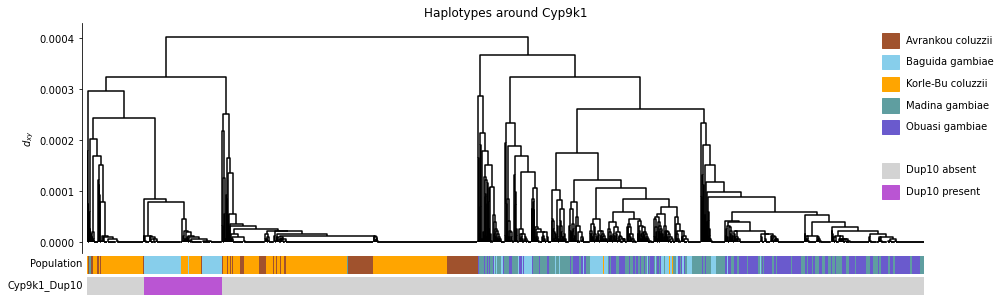

In [18]:
# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap, metric = 'hamming')
site_filter = ag3.snp_calls(region=region, sample_sets="3.2")['variant_filter_pass_gamb_colu']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * loc_hap.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup10_hap_status = np.array(['Dup10 absent', 'Dup10 present'])[Dup10_hap_proxy]
draw_hap_cluster_plot(z, r, loc_hap, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup10_colours,
                      labels_for_pop_colours = hap_meta['loc_sp'], 
                      labels_for_cnv_colours = Dup10_hap_status, 
                      title = 'Haplotypes around Cyp9k1',
                      fn = 'Cyp9k1_haplotype_clustering.png'
)